In [2]:
import torch.nn as nn
import math
from torchsummary import summary
import pdb

# 첫번째 layer에서 사용될 convolution 함수
def conv_bn(inp, oup, stride):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 3, stride, 1, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

# inverted bottleneck layer 바로 다음에 나오는 convolution에 사용될 함수
def conv_1x1_bn(inp, oup):
    return nn.Sequential(
        nn.Conv2d(inp, oup, 1, 1, 0, bias=False),
        nn.BatchNorm2d(oup),
        nn.ReLU6(inplace=True)
    )

# channel수를 무조건 8로 나누어 떨어지게 만드는 함수
def make_divisible(x, divisible_by=8):
    import numpy as np
    return int(np.ceil(x * 1. / divisible_by) * divisible_by)


class InvertedResidual(nn.Module):

    def __init__(self, inp, oup, stride, expand_ratio):
        super(InvertedResidual,self).__init__()
        self.stride = stride
        assert stride in [1,2]

        hidden_dim = int(inp * expand_ratio)  # expansion channel
        self.use_res_connect = self.stride == 1 and inp == oup  # skip connection이 가능한지 확인 True or False
        '''
        self.stride == 1 ----> 연산 전 후의 feature_map size가 같다는 의미
        inp == oup ----> 채널수도 동일하게 유지된다는 의미
        즉 skip connection 가능
        '''
        if expand_ratio == 1:
            self.conv = nn.Sequential(
                # 확장시킬 필요가 없기 때문에 바로 depth wise conv
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup)
            )
        else:
            self.conv = nn.Sequential(
                # pw(확장)
                nn.Conv2d(inp, hidden_dim, 1, 1, 0, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # dw
                nn.Conv2d(hidden_dim, hidden_dim, 3, stride, 1, groups=hidden_dim, bias=False),
                nn.BatchNorm2d(hidden_dim),
                nn.ReLU6(inplace=True),
                # pw-linear(축소)
                nn.Conv2d(hidden_dim, oup, 1, 1, 0, bias=False),
                nn.BatchNorm2d(oup)
            )

    def forward(self, x):
        if self.use_res_connect:
            return x + self.conv(x)  # skip connection (element wise sum)
        else:
            return self.conv(x)


class MobileNetV2(nn.Module):

    def __init__(self, n_class=1000, input_size=224, width_mult=1.):
        super(MobileNetV2, self).__init__()
        block = InvertedResidual
        input_channel = 32
        last_channel = 1280

        interverted_residual_setting = [
            # t, c, n, s
            # t : expand ratio
            # c : channel
            # n : Number of iterations
            # s : stride
            [1, 16, 1, 1],
            [6, 24, 2, 2],
            [6, 32, 3, 2],
            [6, 64, 4, 2],
            [6, 96, 3, 1],
            [6, 160, 3, 2],
            [6, 320, 1, 1]
        ]

        # building first layer
        assert input_size % 32 == 0
        # input_channel = make_divisible(input_channel * width_mult)
        self.last_channel = make_divisible(last_channel * width_mult) if width_mult > 1.0 else last_channel
        self.features = [conv_bn(3, input_channel, 2)]  # feature들을 담을 리스트에 first layer 추가

        # building inverted residual blocks
        for t, c, n, s in interverted_residual_setting:
            output_channel = make_divisible(c * width_mult) if t > 1 else c
            for i in range(n):
                if i == 0:
                    self.features.append(block(input_channel, output_channel, s, t))
                else:
                    self.features.append(block(input_channel, output_channel, 1, t))  # 반복되는 부분에서 skip connection 가능
                input_channel = output_channel
        # building last several layers
        self.features.append(conv_1x1_bn(input_channel, self.last_channel))  # (batch, 320, 7, 7) -> (batch, 1280, 7, 7)
        # make it nn.Sequential
        self.features = nn.Sequential(*self.features)

        # Average pooling layer
        self.avg = nn.AvgPool2d(7, 7)
        # building classifier
        self.classifier = nn.Linear(self.last_channel, n_class)

        self._initialize_weights()

    def forward(self, x):
        # pdb.set_trace()
        x = self.features(x)
        x = self.avg(x)
        x = x.view(-1, self.last_channel)
        x = self.classifier(x)
        return x

    # 초기 weight 설정
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                if m.bias is not None:
                    m.bias.data.zero_()
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                n = m.weight.size(1)
                m.weight.data.normal_(0, 0.01)
                m.bias.data.zero_()


def mobilenet_v2(pretrained=True):
    model = MobileNetV2(width_mult=1)

    if pretrained:
        try:
            from torch.hub import load_state_dict_from_url
        except ImportError:
            from torch.utils.model_zoo import load_url as load_state_dict_from_url
        state_dict = load_state_dict_from_url(
            'https://www.dropbox.com/s/47tyzpofuuyyv1b/mobilenetv2_1.0-f2a8633.pth.tar?dl=1', progress=True)

        model.load_state_dict(state_dict)
    return model

In [3]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import gc
gc.collect()
torch.cuda.empty_cache()

device = 'cuda' if torch.cuda.is_available() else 'cpu'

train_path = 'C:/Users/User/Desktop/졸음운전/mobilenet/seg_train/seg_train'
test_path = 'C:/Users/User/Desktop/졸음운전/mobilenet/seg_test/seg_test'
pred_path = 'C:/Users/User/Desktop/졸음운전/mobilenet/seg_pred/seg_pred'

train_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize((.5, .5, .5), (.5, .5, .5))
])

train_dataset = datasets.ImageFolder(train_path, transform=train_transform)
test_dataset = datasets.ImageFolder(test_path, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=0, pin_memory=False)

classes = os.listdir(train_path)

model = mobilenet_v2(True)
model.classifier = nn.Linear(model.classifier.in_features, len(classes)).to(device)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
best_acc = 0
epochs = 5

In [4]:
def train(epoch):
    model.train()

    train_loss = 0
    correct = 0
    total = 0

    for index, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
        if (index+1) % 20 == 0:
            print(f'[Train] | epoch: {epoch+1}/{epochs} | batch: {index+1}/{len(train_loader)}| loss: {loss.item():.4f} | Acc: {correct / total * 100:.4f}')


def test(epoch):
    global best_acc
    model.eval() 
    test_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for index, (inputs, targets) in enumerate(test_loader):

            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
         
            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
        print(f'[Test] epoch: {epoch+1} loss: {test_loss:.4f} | Acc: {correct / total * 100:.4f}')
          


    # Save checkpoint.   
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if not os.path.isdir('checkpoint'): 
            os.mkdir('checkpoint')
        torch.save(state, './checkpoint/ckpt.pth')
        best_acc = acc
        
        
for epoch in range(epochs):
    train(epoch)
    test(epoch)

[Train] | epoch: 1/5 | batch: 20/3509| loss: 2.0812 | Acc: 15.0000
[Train] | epoch: 1/5 | batch: 40/3509| loss: 1.7697 | Acc: 18.7500
[Train] | epoch: 1/5 | batch: 60/3509| loss: 1.9365 | Acc: 18.7500
[Train] | epoch: 1/5 | batch: 80/3509| loss: 1.8085 | Acc: 21.8750
[Train] | epoch: 1/5 | batch: 100/3509| loss: 1.8736 | Acc: 26.0000
[Train] | epoch: 1/5 | batch: 120/3509| loss: 1.3424 | Acc: 28.5417
[Train] | epoch: 1/5 | batch: 140/3509| loss: 1.8187 | Acc: 29.8214
[Train] | epoch: 1/5 | batch: 160/3509| loss: 1.2920 | Acc: 33.2812
[Train] | epoch: 1/5 | batch: 180/3509| loss: 1.2567 | Acc: 36.2500
[Train] | epoch: 1/5 | batch: 200/3509| loss: 1.1983 | Acc: 38.2500
[Train] | epoch: 1/5 | batch: 220/3509| loss: 1.4893 | Acc: 39.7727
[Train] | epoch: 1/5 | batch: 240/3509| loss: 1.1455 | Acc: 42.5000
[Train] | epoch: 1/5 | batch: 260/3509| loss: 1.0369 | Acc: 43.6538
[Train] | epoch: 1/5 | batch: 280/3509| loss: 1.5472 | Acc: 45.9821
[Train] | epoch: 1/5 | batch: 300/3509| loss: 1.6906

<Figure size 432x288 with 0 Axes>

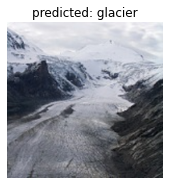

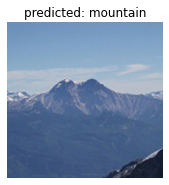

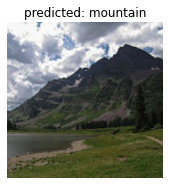

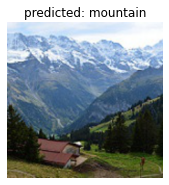

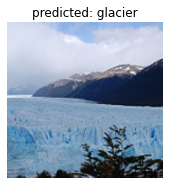

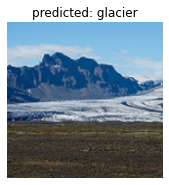

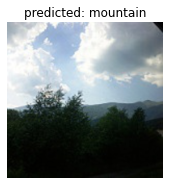

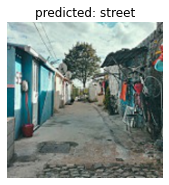

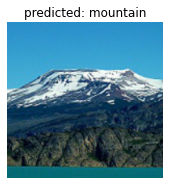

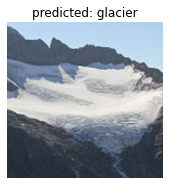

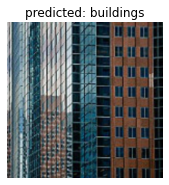

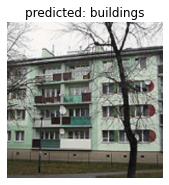

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from PIL import Image
import time
import torchvision


class Archive(Dataset):
    def __init__(self, path, transform=None):
        img_name = [f for f in os.listdir(path)]
        self.imgList = [os.path.join(path, i) for i in img_name]
        self.path = path
        self.transform = transform

    def __len__(self):
        return len(self.imgList)

    def __getitem__(self, idx):
        image = Image.open(self.imgList[idx]).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)
        return image


def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def visualize_model(model, num_images=12):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, inputs in enumerate(pred_loader):
            inputs = inputs.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
 
            for j in range(inputs.size()[0]):
                images_so_far += 1
                plt.figure(figsize=(20,20))
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(classes[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

if __name__ == '__main__':

    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_path = 'C:/Users/User/Desktop/졸음운전/mobilenet/seg_train/seg_train'
    pred_path = 'C:/Users/User/Desktop/졸음운전/mobilenet/seg_pred/seg_pred'
    classes = sorted(os.listdir(train_path))

    pred_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((.5, .5, .5), (.5, .5, .5))
    ])

    pred_dataset = Archive(pred_path, transform=pred_transform)
    pred_loader = DataLoader(pred_dataset, batch_size=4, shuffle=True, num_workers=0, pin_memory=False)

    model = mobilenet_v2(False)
    model.classifier = nn.Linear(model.classifier.in_features, len(classes)).to(device)  # 1000 -> 6

    checkpoint = torch.load('C:/KM LEE/MobileNet/checkpoint/ckpt.pth')
    model.load_state_dict(checkpoint['model'])

    model = model.to(device)
    visualize_model(model)